# FAST EXACT TOMOGRAPHIC PROJECTION WITH BASIS FUNCTIONS

This notebook documents the implementation of a novel approach to tomography using spline basis functions instead of pixels. The goal is to compute the x-ray transform in an exact and efficient manner. The technique presented here offers a fast and accurate alternative to traditional pixel-based tomographic methods. This notebook serves as a comprehensive guide to understanding and implementing the proposed approach.


In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

This code supports efficient GPU computation. The computation of the X-ray operator takes advantage of a fine-grained parallelism implementation via ray-tracing.


In [2]:
cp.cuda.Device(0).use()

<CUDA Device 0>

Definition of the geometry of the problem

In [3]:
N_side = 5000 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]
phantom = np.zeros((N_side, N_side))

xx = np.linspace(-N_side//2,N_side//2, num=N_side)
yy = xx
X, Y = np.meshgrid(xx,yy)
r = 700
mask = np.sqrt(X**2 + Y**2) < r
phantom = np.exp(-((X-500)**2 + (Y+400)**2)/400000) + 0.5*np.exp(-((X+700)**2 + (Y-700)**2)/400000)

arg_shape = phantom.shape
'''
plt.figure('Phantom')
plt.imshow(phantom, cmap='gray')
plt.title('Phantom')
plt.colorbar()
plt.show()

N_angle  = 30 #30 20 old
N_offset = 50 #50

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)'''

"\nplt.figure('Phantom')\nplt.imshow(phantom, cmap='gray')\nplt.title('Phantom')\nplt.colorbar()\nplt.show()\n\nN_angle  = 30 #30 20 old\nN_offset = 50 #50\n\n# Let's build the necessary components to instantiate the operator . ========================\nangles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)\n\nn = np.stack([np.cos(angles), np.sin(angles)], axis=1)\n\nt        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0\nt_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius\nt_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)\n\nn_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)\nt_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)\nt_spec += pitch * N_side / 2  # Move anchor point to the center of volume.\nextra   = np.ones((1,N_angle*N_offset,1))\norigin  = (0., 0.)\npitch   = (1.,1.)\n\n# Convert to cupy arrays\nphantom = cp.array(phantom)\nt_spec  = cp.array(t_spec)\nn_

### Definition of the operators 
> X-ray transform with splines-basis functions of degree 0 (pixels), 1, or 2.

\begin{equation}
    \mathcal{P}_{\theta}\{f\}(z) = \int_{\mathbb{R}} f(t \theta+{P}_{\theta^{\perp}}^{T}z)\ \mathrm{d} t,
\end{equation}

/home/haouchat/cryo-ct/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/cryo-ct/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


sample normal
norm diff splines :  24.457156441652824
norm diff pixels  :  14.39013499190216


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Oversampled
norm diff splines :  224.77034493431802
norm diff pixels  :  4254.276445719575
187.1366899624187
7.139001507228479


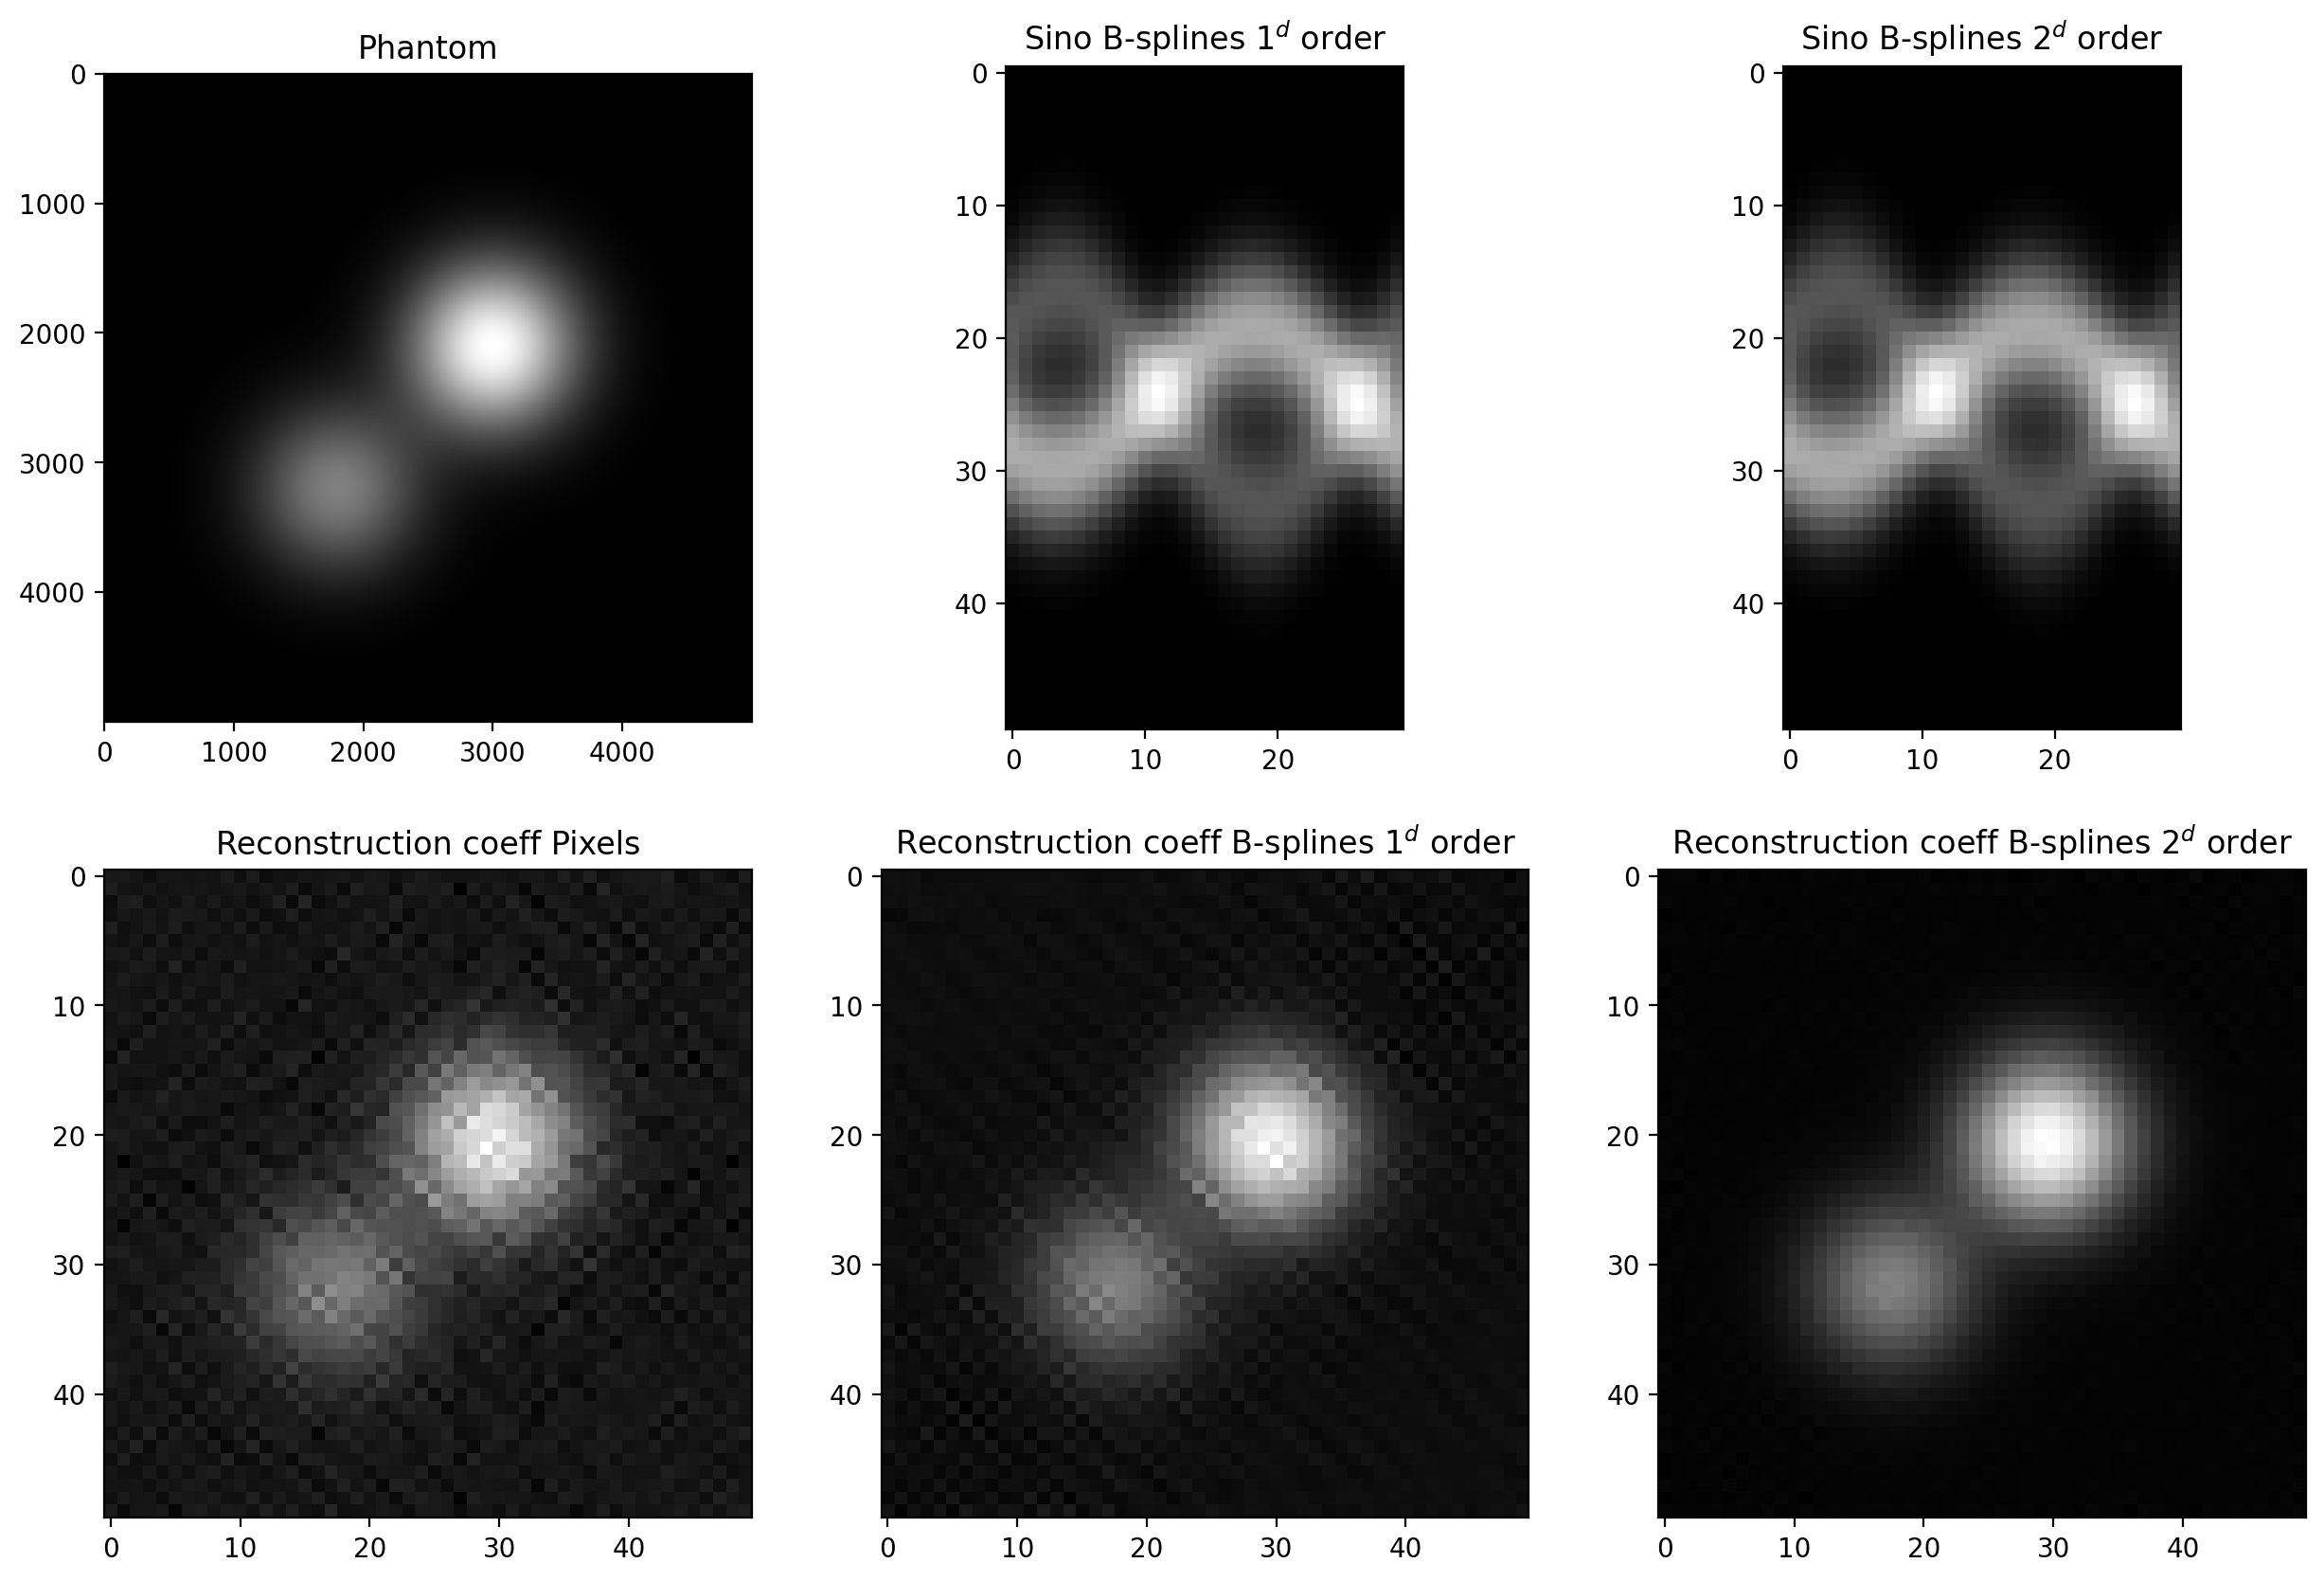

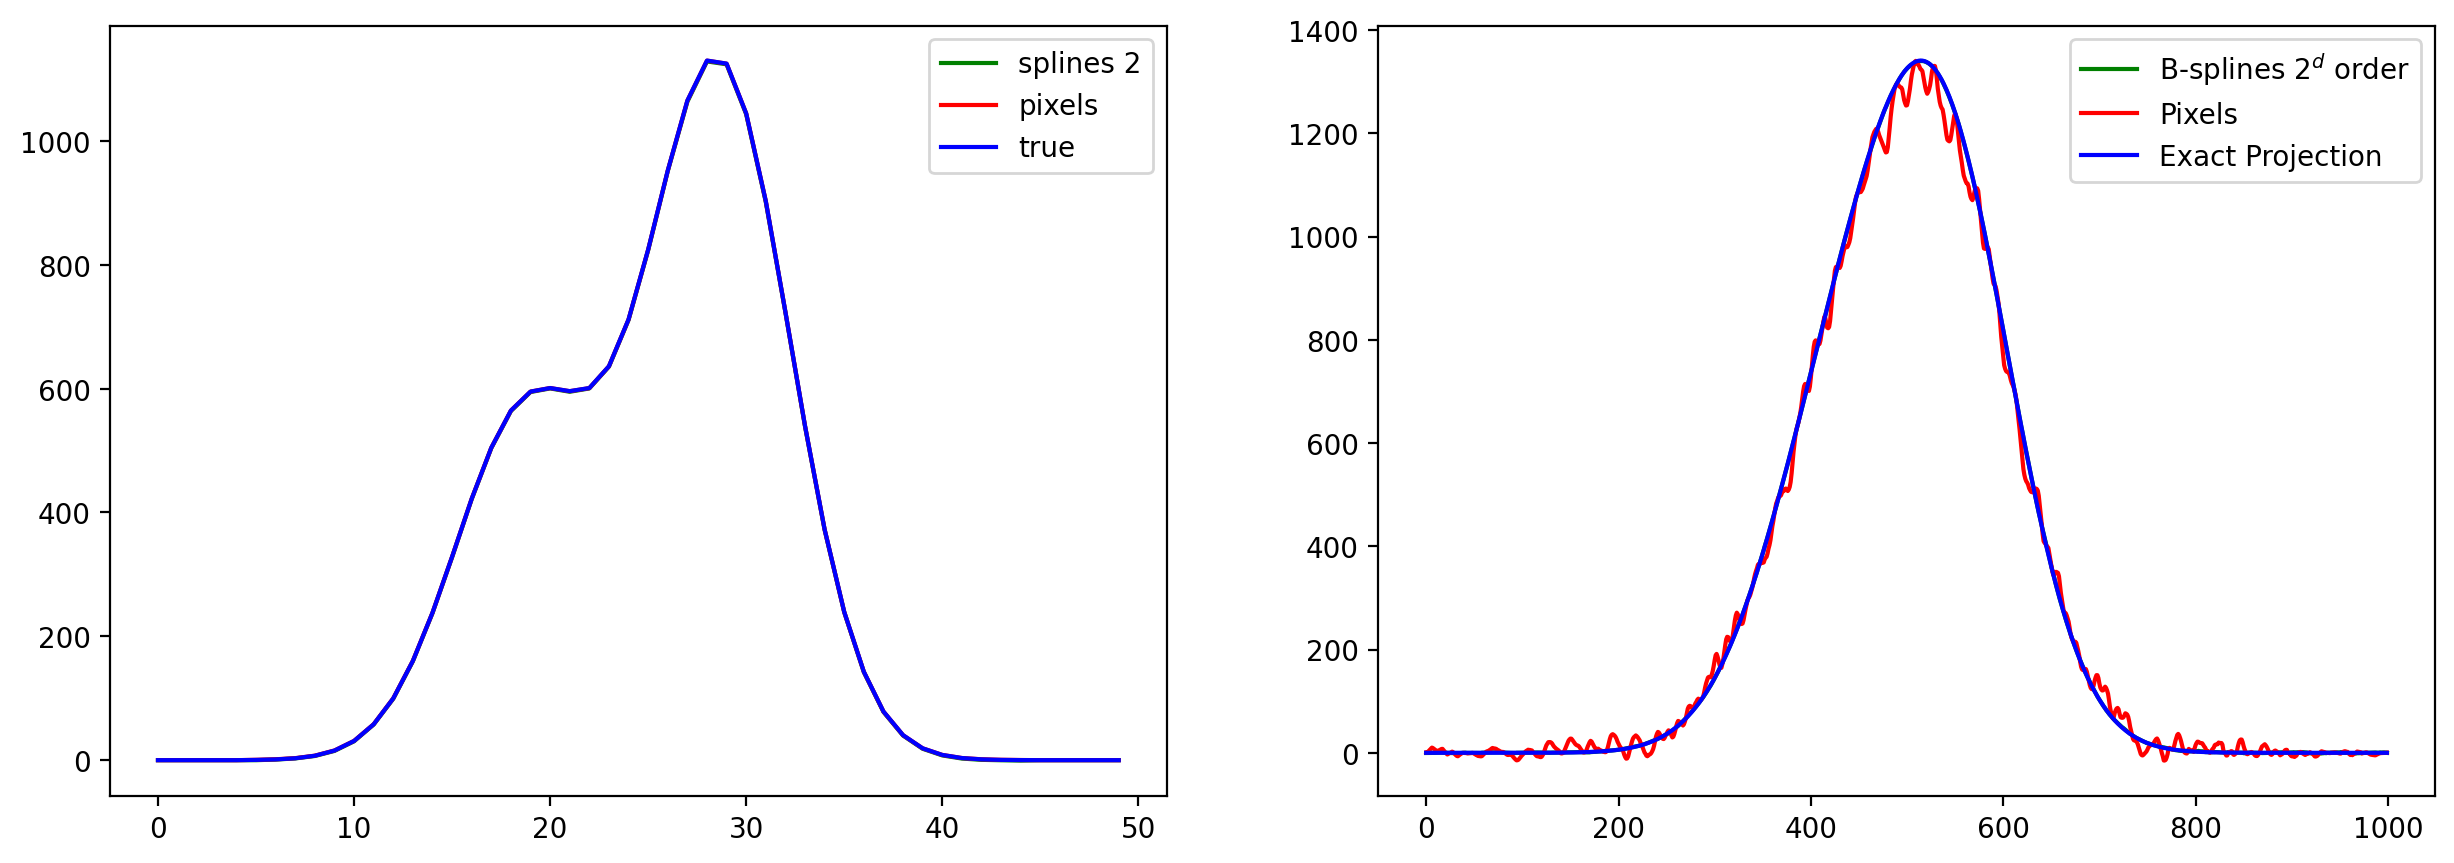

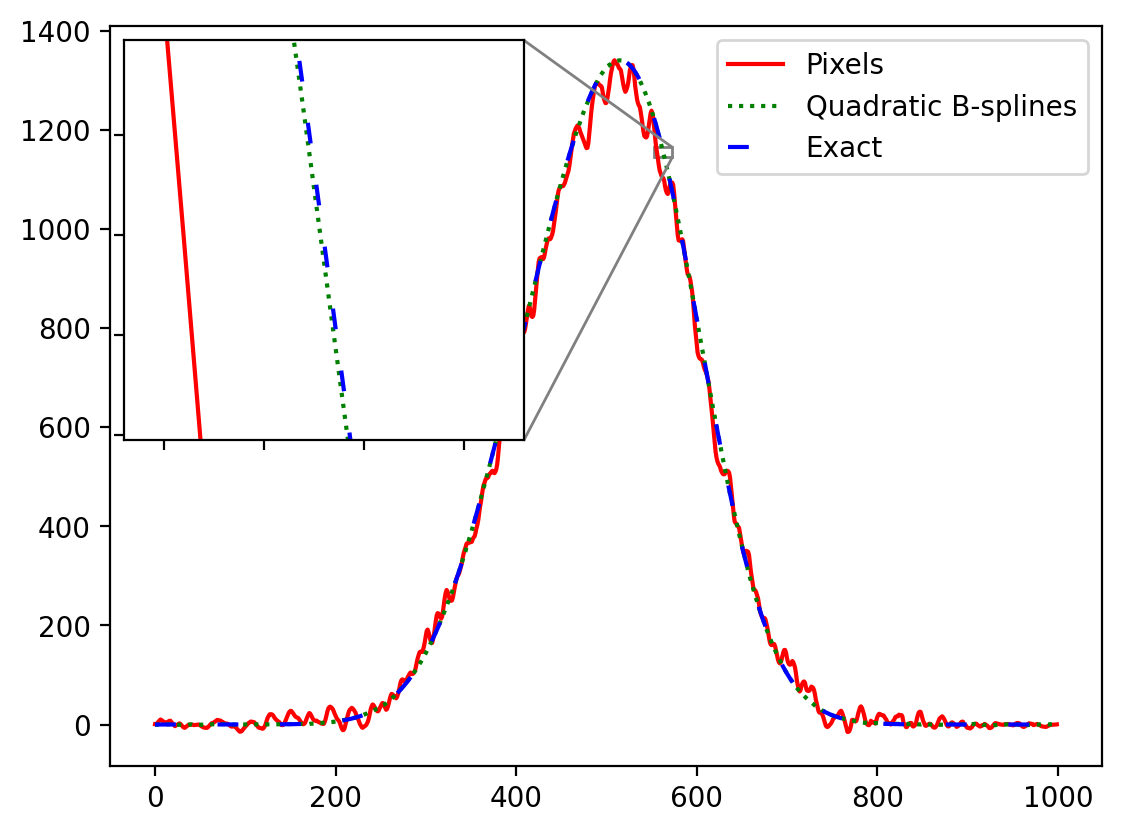

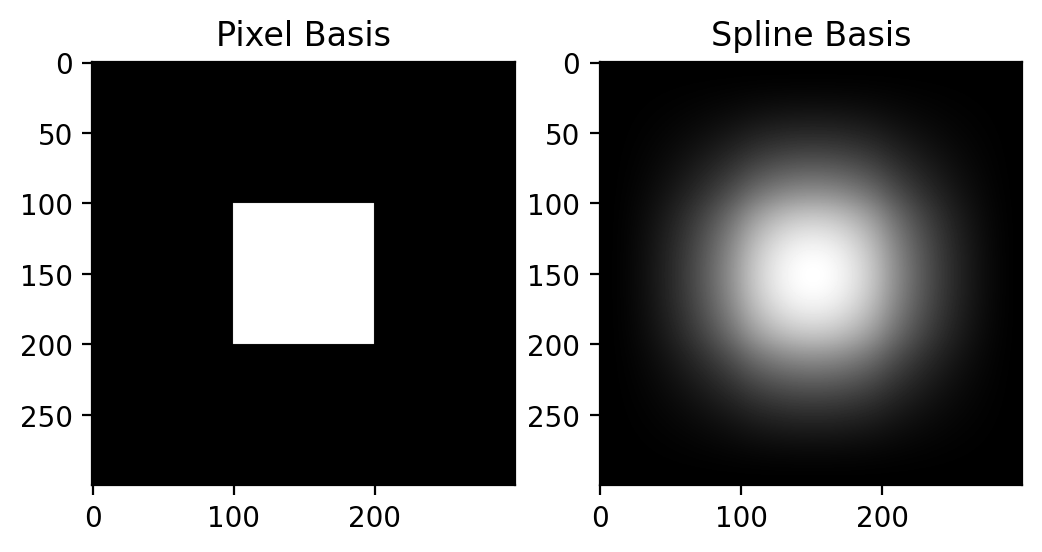

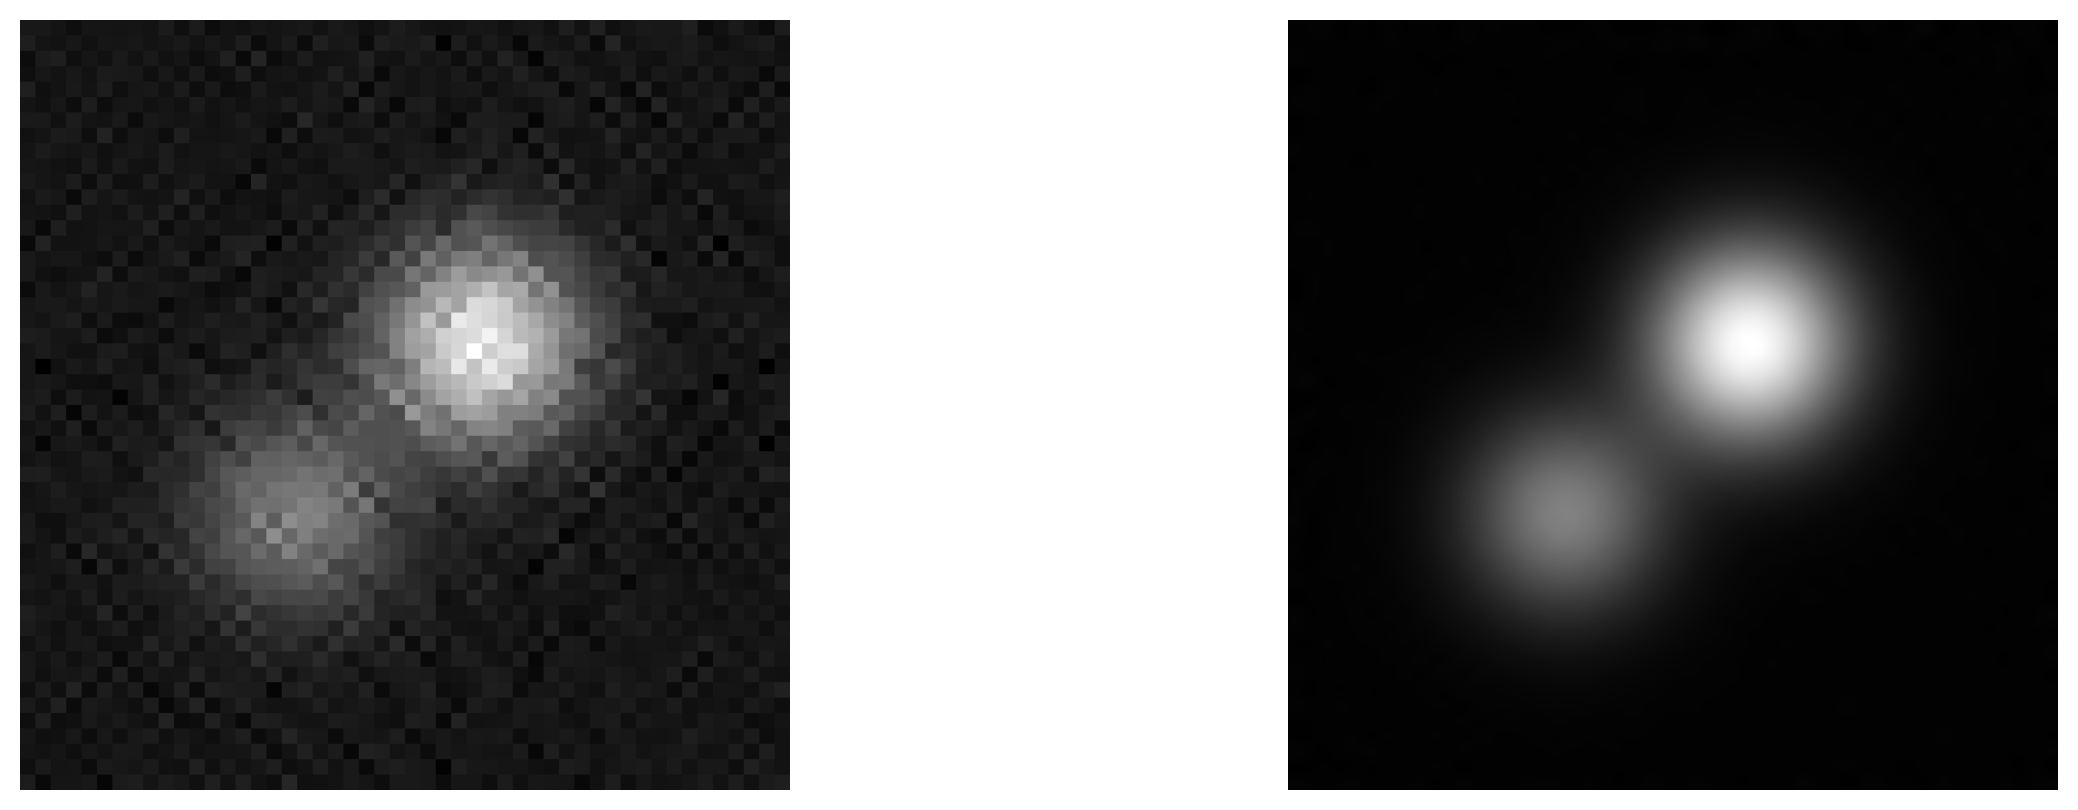

In [4]:
%config InlineBackend.figure_format = 'retina'

N_side = 5000 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]
phantom = np.zeros((N_side, N_side))

#phantom[N_side//2-30: N_side//2+30, N_side//2-30: N_side//2+30 ] = 1
xx = np.linspace(-N_side//2,N_side//2, num=N_side)
yy = xx
X, Y = np.meshgrid(xx,yy)
r = 700
mask = np.sqrt(X**2 + Y**2) < r
phantom = np.exp(-((X-500)**2 + (Y+400)**2)/400000) + 0.5*np.exp(-((X+700)**2 + (Y-700)**2)/400000)

# phantom = np.zeros((N_side, N_side))
# phantom[N_side//2 - 1000:N_side//2 + 1000, N_side//2 - 1000:N_side//2 + 1000] = 1
arg_shape = phantom.shape



N_angle  = 30 #30 20 old
N_offset = 50 #50

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)


#N_angle  = 50
N_offset_true = 1000
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset_true, endpoint=True)

n_spec_true  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset_true, 2))  # (N_angle, N_offset_true, 2)
t_spec_true  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset_true, 1)  # (N_angle, N_offset_true, 2)
t_spec_true += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset_true,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec_true  = cp.array(t_spec_true)
n_spec_true  = cp.array(n_spec_true)

op_true = pxr.XRayTransform.init( #for reconstruction
    arg_shape=arg_shape,
    t_spec=t_spec_true.reshape(-1,2), 
    n_spec=n_spec_true.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels


# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU
sinogram_astra = fwd_pixels

stop_crit = pxst.MaxIter(30) #30 before

oversampling = 50
op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)

#add noise
#y_data = np.array(y_data.get()) + 20*np.random.random(y_data.shape)
#y_data = cp.array(y_data)
recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_splines_1.T, cmap='gray')
axes[0, 1].set_title('Sino B-splines $1^d$ order')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()


#N_angle  = 50
N_offset = 1000 
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

#dotted lines
ax.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')
axins.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')

#dashed lines
ax.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))
axins.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))

x_baseline = 563
y_true = true_proj[9][x_baseline]
x1, x2, y1, y2 = x_baseline-10, x_baseline+10, y_true-10, y_true+10
#505+10, 505+20, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()
plt.savefig('inset.eps', format='eps')

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

# Upsampling to approach continuum

mini_im = np.zeros((300,300))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[100:200, 100:200] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#plt.figure('pix upsampling')
#plt.imshow(mini_im_pix, cmap='gray')
ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[100:200, 100:200], mode='same')/100**2
mini_im_spline = spconv(mini_im_spline, mini_im_pix[100:200, 100:200], mode='same')/100**2
#plt.figure()
#plt.imshow(mini_im_spline)
ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((5200,5200))
for i in range(50):
    for j in range(50):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((5200,5200))
for i in range(50):
    for j in range(50):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('upsampled pix')
#plt.imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
#ax[0].set_title('Upsampled pixel reconstruction')
#plt.figure('upsampled spline')
#plt.imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[1].imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
#ax[1].set_title('Upsampled spline reconstruction')
#remove axis
for a in ax:
    a.axis('off')
plt.savefig('upsampled.eps', format='eps')

#plt.figure('diff pix')
#plt.imshow(full_im_pix[100:-100, 100:-100] - phantom.get(), cmap='gray')
#plt.figure('diff splines')
#plt.imshow(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get(), cmap='gray')


print(np.linalg.norm(full_im_pix[100:-100, 100:-100] - phantom.get()))
print(np.linalg.norm(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get()))
plt.show()

One non zero coefficient


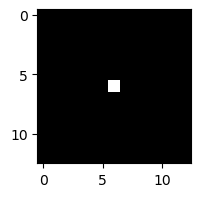

In [5]:
N_side = 13 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]
phantom = np.zeros((N_side, N_side))

phantom[ N_side//2, N_side//2 ] = 1

arg_shape = phantom.shape

plt.figure(figsize=(2,2))
plt.imshow(phantom, cmap='gray')

N_angle  = 100 
N_offset = 5000 

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
#angles = np.array([3.145])
n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
print('One non zero coefficient')

Angle :  0.0
Angle :  0.06283185307179587
Angle :  0.12566370614359174
Angle :  0.1884955592153876
Angle :  0.25132741228718347
Angle :  0.3141592653589793
Angle :  0.3769911184307752
Angle :  0.4398229715025711
Angle :  0.5026548245743669
Angle :  0.5654866776461628
Angle :  0.6283185307179586
Angle :  0.6911503837897546
Angle :  0.7539822368615504
Angle :  0.8168140899333463
Angle :  0.8796459430051422
Angle :  0.942477796076938
Angle :  1.0053096491487339
Angle :  1.0681415022205298
Angle :  1.1309733552923256
Angle :  1.1938052083641215
Angle :  1.2566370614359172
Angle :  1.3194689145077132
Angle :  1.3823007675795091
Angle :  1.4451326206513049
Angle :  1.5079644737231008
Angle :  1.5707963267948968
Angle :  1.6336281798666925
Angle :  1.6964600329384885
Angle :  1.7592918860102844
Angle :  1.8221237390820801
Angle :  1.884955592153876
Angle :  1.9477874452256718
Angle :  2.0106192982974678
Angle :  2.0734511513692637
Angle :  2.1362830044410597
Angle :  2.199114857512855
Angle :

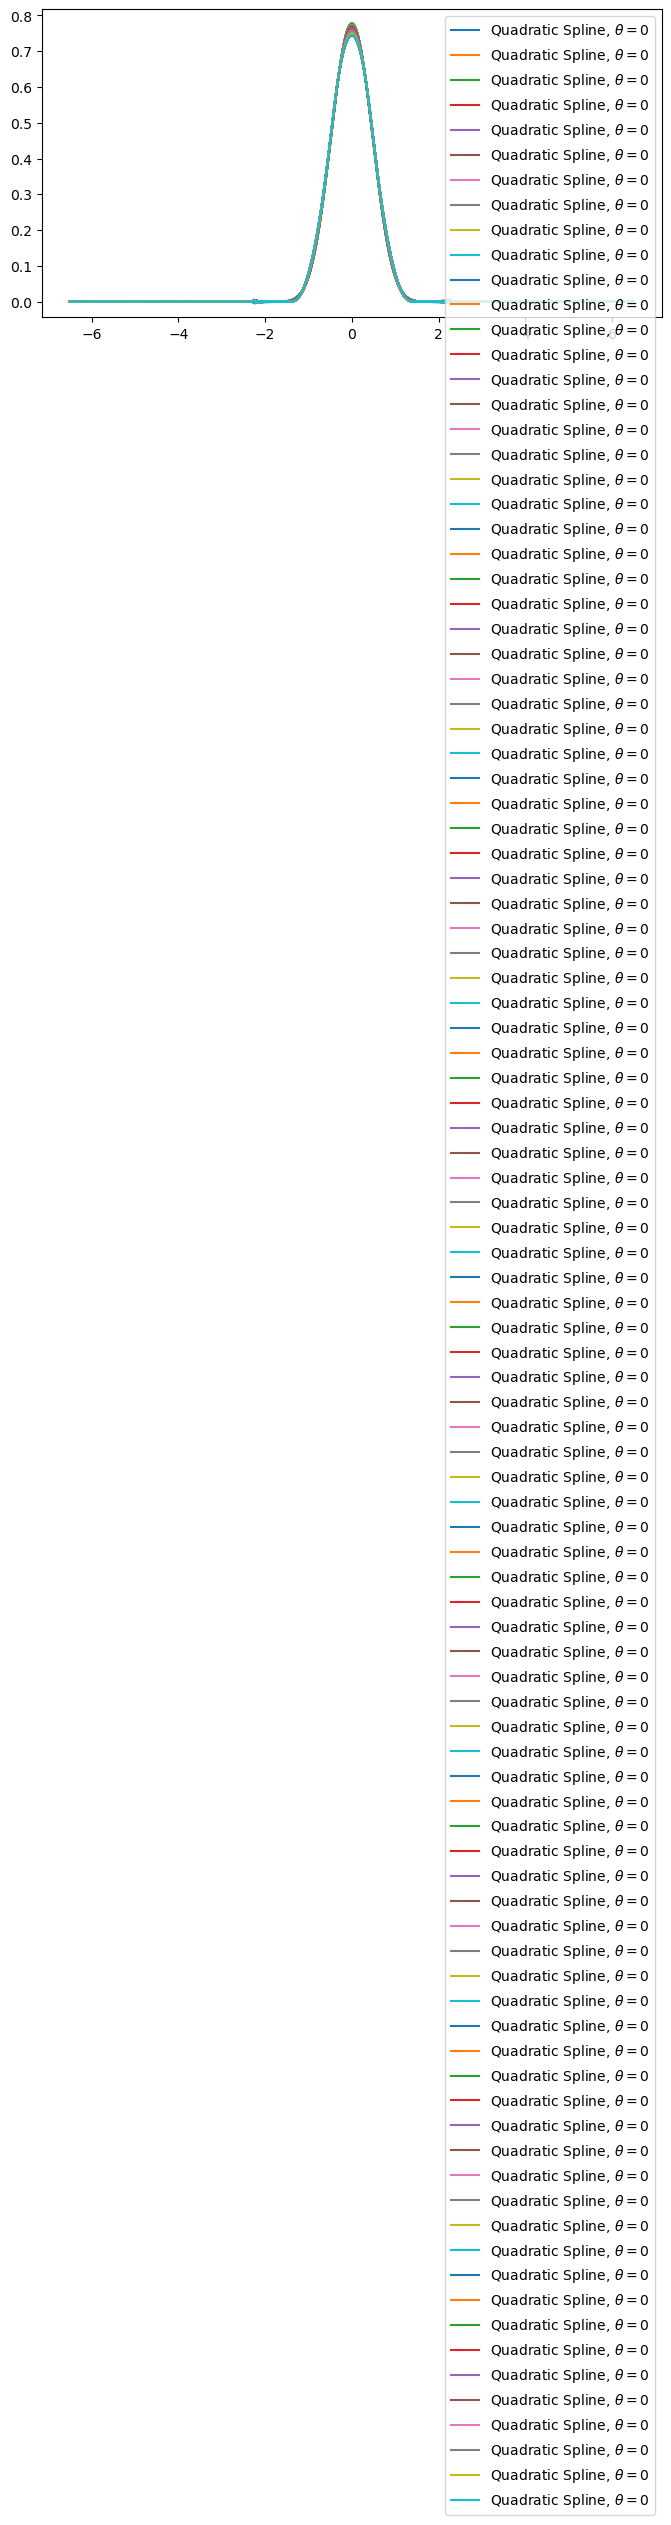

In [6]:
fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

plt.figure('X-ray spline Projection', figsize=(8,4))
for k in range(len(angles)):
    num = k
    
    #if num!=0 and num!= 50:
    print('Angle : ', angles[num])
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$')

    plt.legend()

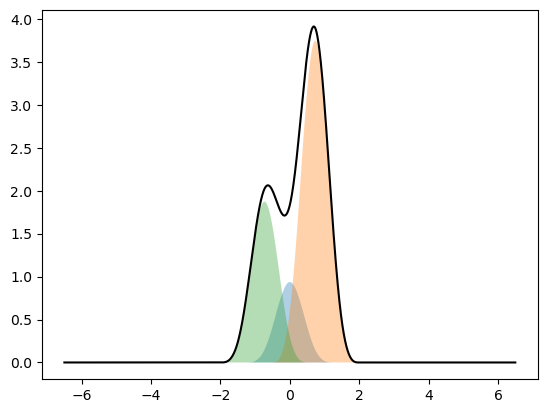

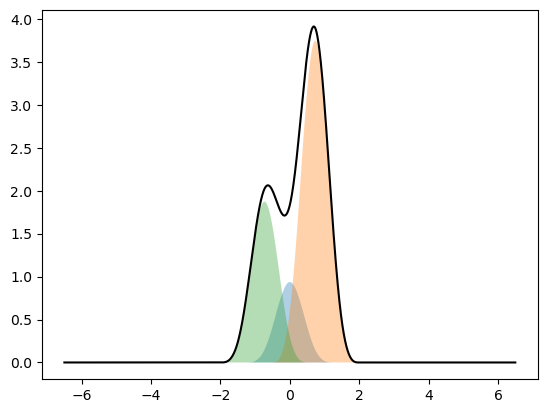

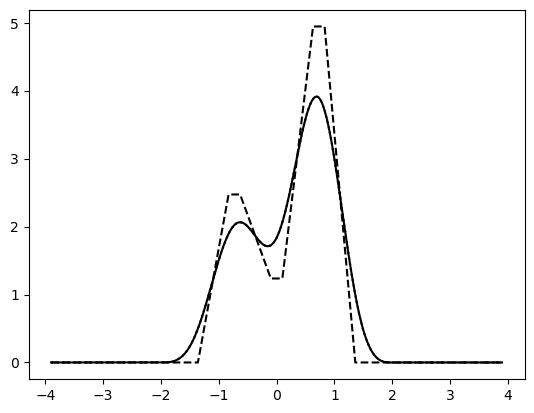

In [6]:
plt.figure('Spline construction : CPWL')
for k in range(len(angles)):
    num = k
    
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 0
    phantom[N_side//2,N_side//2+1] = 4
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    
    phantom[N_side//2,N_side//2+1] = 0
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 1
    phantom[N_side//2,N_side//2+1] = 4
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], color='k')

plt.savefig('cpwl_construction.png', format='png')

plt.figure('Spline construction : CPWQ')
for k in range(len(angles)):
    num = k
    
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 0
    phantom[N_side//2,N_side//2-1] = 0
    phantom[N_side//2,N_side//2+1] = 4
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    
    phantom[N_side//2,N_side//2+1] = 0
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 1
    phantom[N_side//2,N_side//2+1] = 4
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], color='k')
    
#phantom[N_side//2,N_side//2] = 0 test ici pour git
#phantom[N_side//2,N_side//2+1] = 0
#phantom[N_side//2,N_side//2-1] = 0
fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

plt.savefig('cpwq_construction.png', format='png')

plt.figure('X-ray Box-splines')

for k in range(len(angles)):
    num = k
    #print((np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num]))[1000:-1000]))
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num]))[1000:-1000], fwd_pixels[num][1000:-1000], label=r'Pixel, $\theta=0$', c='black', linestyle='dashed')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num]))[1000:-1000], fwd_splines_1[num][1000:-1000], label=r'Linear Spline, $\theta=0$', c='black', linestyle='dotted')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num]))[1000:-1000], fwd_splines_2[num][1000:-1000], label=r'Quadratic Spline, $\theta=0$', c='black')

#plt.legend()

plt.savefig('compare_smoothness.eps', format='eps')
plt.show()

## Cone-beam version

In [8]:
%config InlineBackend.figure_format = 'retina'

N_side = 5000 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]
phantom = np.zeros((N_side, N_side))

#phantom[N_side//2-30: N_side//2+30, N_side//2-30: N_side//2+30 ] = 1
xx = np.linspace(-N_side//2,N_side//2, num=N_side)
yy = xx
X, Y = np.meshgrid(xx,yy)
r = 700
mask = np.sqrt(X**2 + Y**2) < r
phantom = np.exp(-((X-500)**2 + (Y+400)**2)/400000) + 0.5*np.exp(-((X+700)**2 + (Y-700)**2)/400000)

# phantom = np.zeros((N_side, N_side))
# phantom[N_side//2 - 1000:N_side//2 + 1000, N_side//2 - 1000:N_side//2 + 1000] = 1
arg_shape = phantom.shape



N_angle  = 30 #30 20 old
N_offset = 50 #50

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)
print(t_spec.shape, n_spec.shape)
print(t_spec)
print(n_spec)

(30, 50, 2) (30, 50, 2)
[[[2500.         -499.4       ]
  [2500.         -376.9755102 ]
  [2500.         -254.55102041]
  ...
  [2500.         5254.55102041]
  [2500.         5376.9755102 ]
  [2500.         5499.4       ]]

 [[3123.61032544 -433.85591364]
  [3098.15684277 -314.10669268]
  [3072.7033601  -194.35747171]
  ...
  [1927.2966399  5194.35747171]
  [1901.84315723 5314.10669268]
  [1876.38967456 5433.85591364]]

 [[3719.96588724 -240.08824565]
  [3670.17136123 -128.2479091 ]
  [3620.37683522  -16.40757254]
  ...
  [1379.62316478 5016.40757254]
  [1329.82863877 5128.2479091 ]
  [1280.03411276 5240.08824565]]

 ...

 [[ 736.99691427   73.43442707]
  [ 808.9562239   172.47791984]
  [ 880.91553352  271.52141262]
  ...
  [4119.08446648 4728.47858738]
  [4191.0437761  4827.52208016]
  [4263.00308573 4926.56557293]]

 [[1280.03411276 -240.08824565]
  [1329.82863877 -128.2479091 ]
  [1379.62316478  -16.40757254]
  ...
  [3620.37683522 5016.40757254]
  [3670.17136123 5128.2479091 ]
  [3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


sample normal
norm diff splines :  24.45908423430342
norm diff pixels  :  14.208570150669674
Oversampled
norm diff splines :  224.76905099053295
norm diff pixels  :  4253.374279297722
187.11627576784738
7.139207978534118


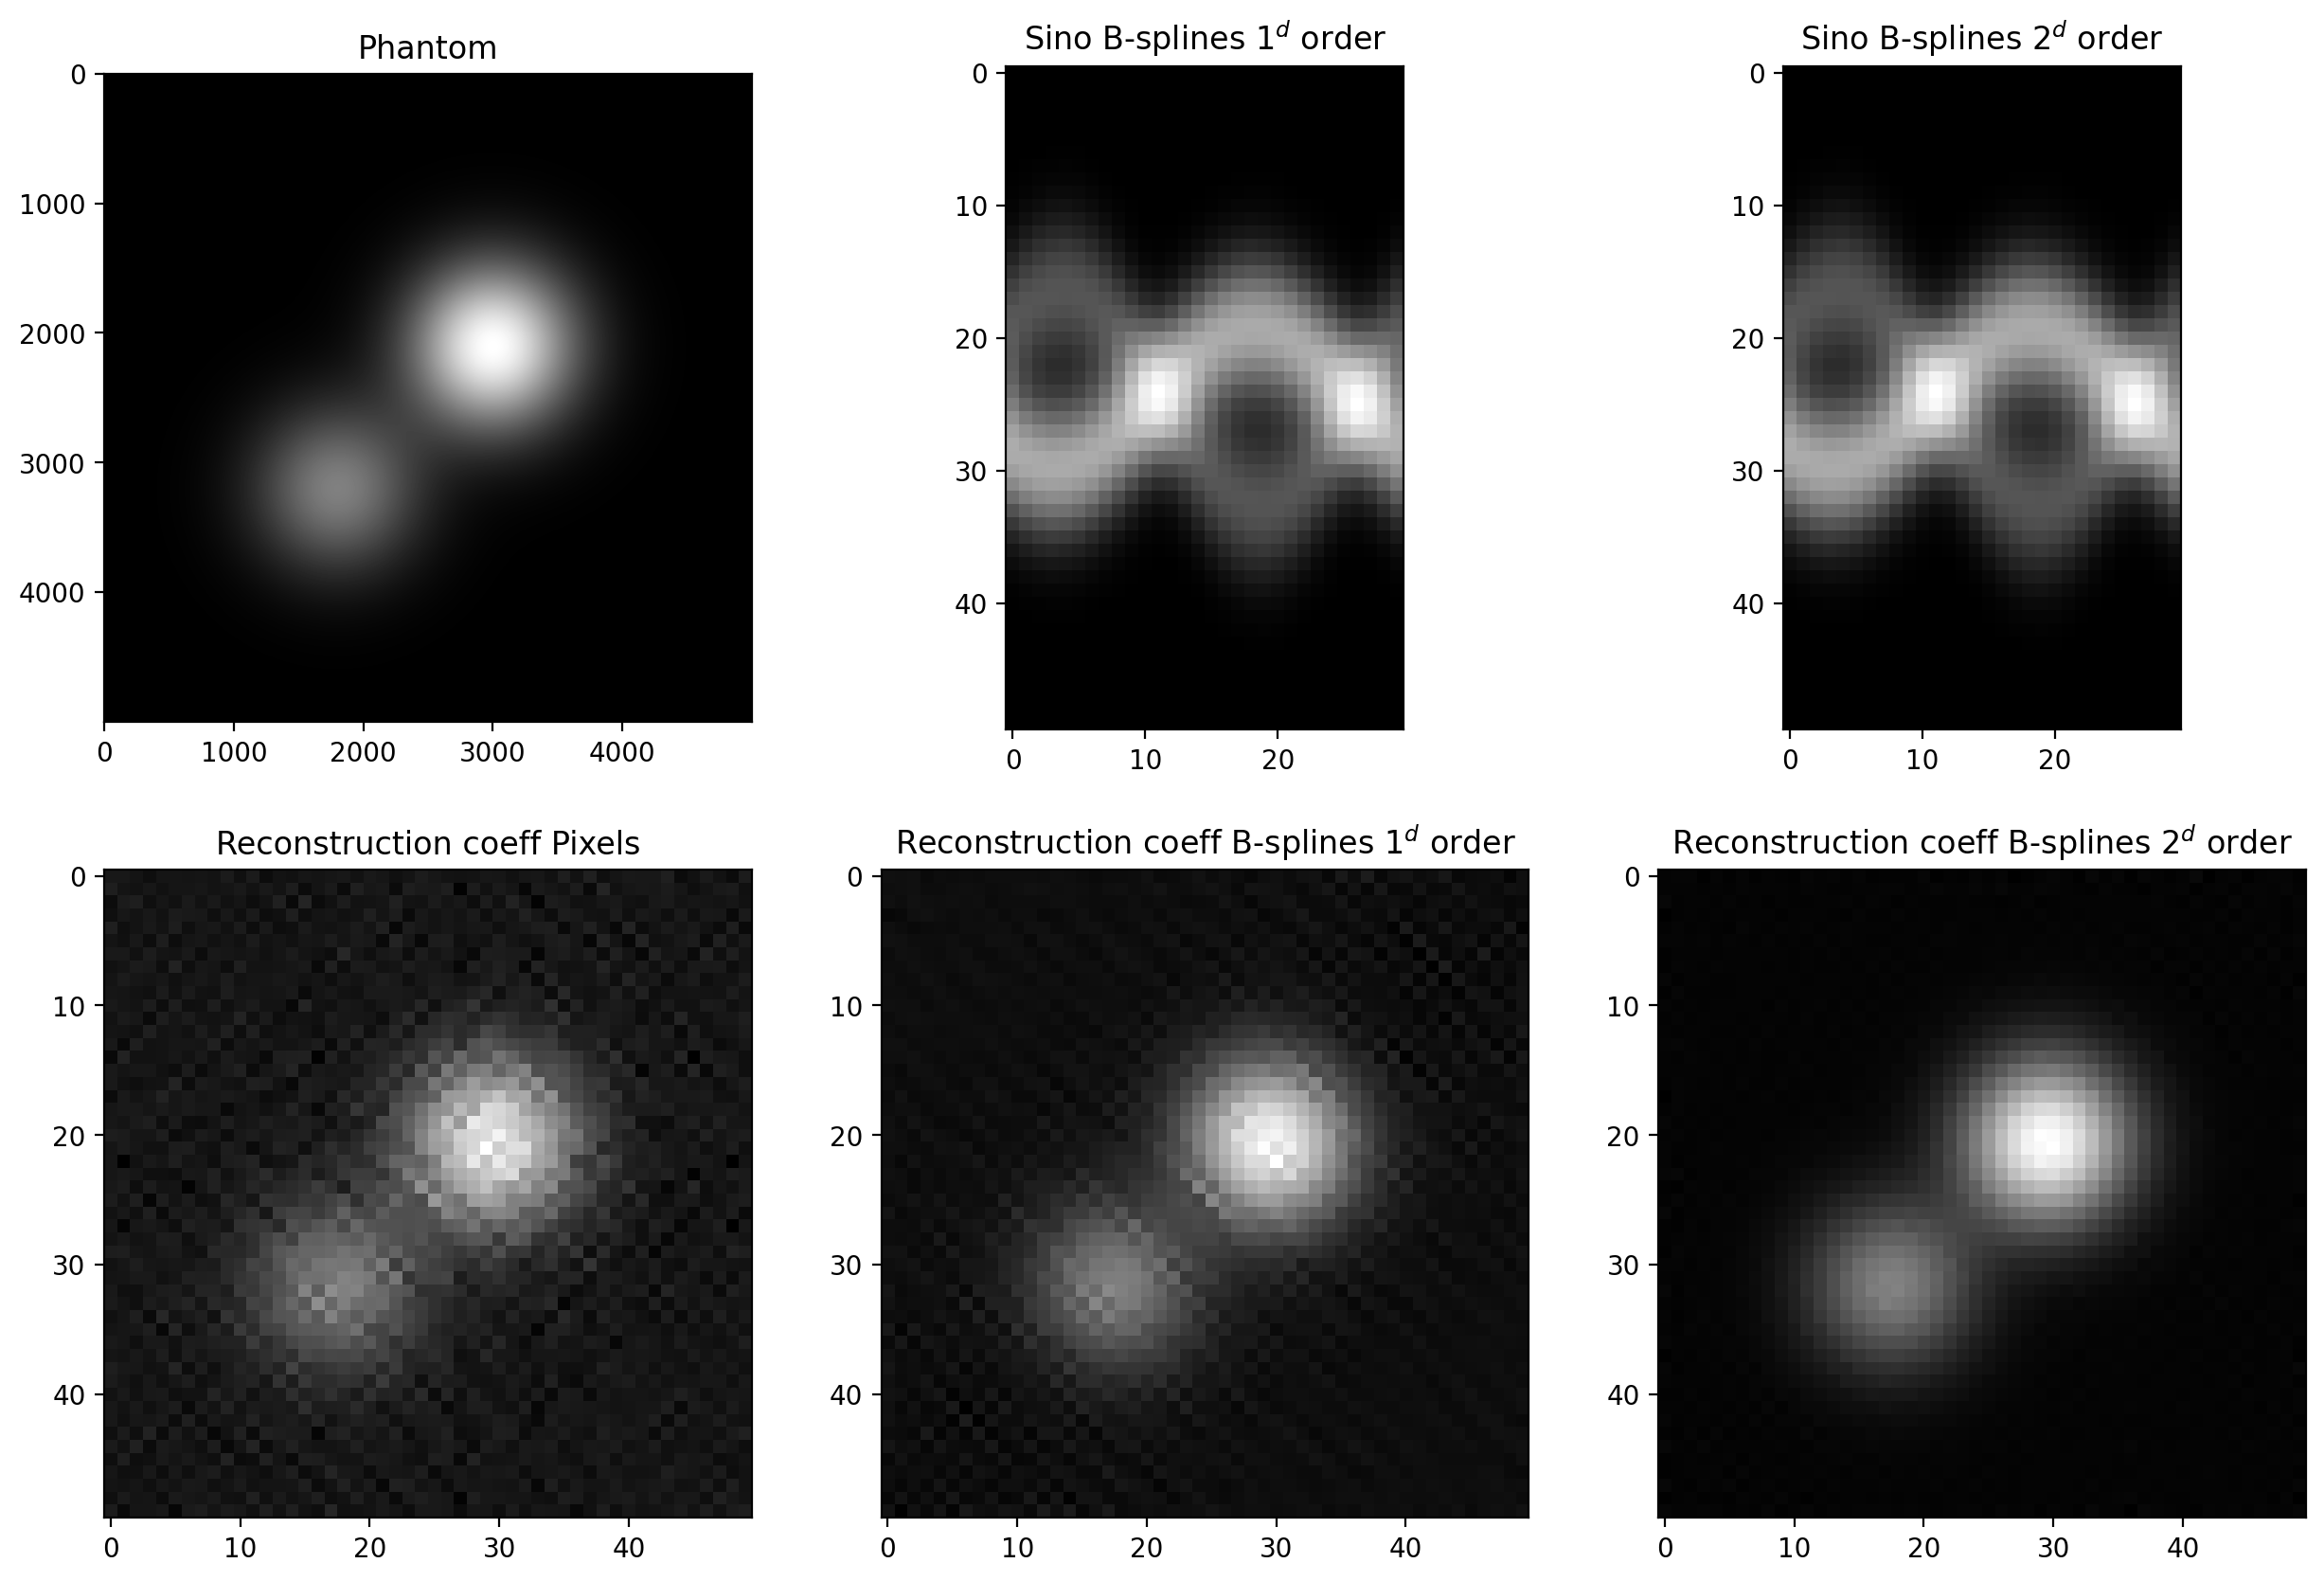

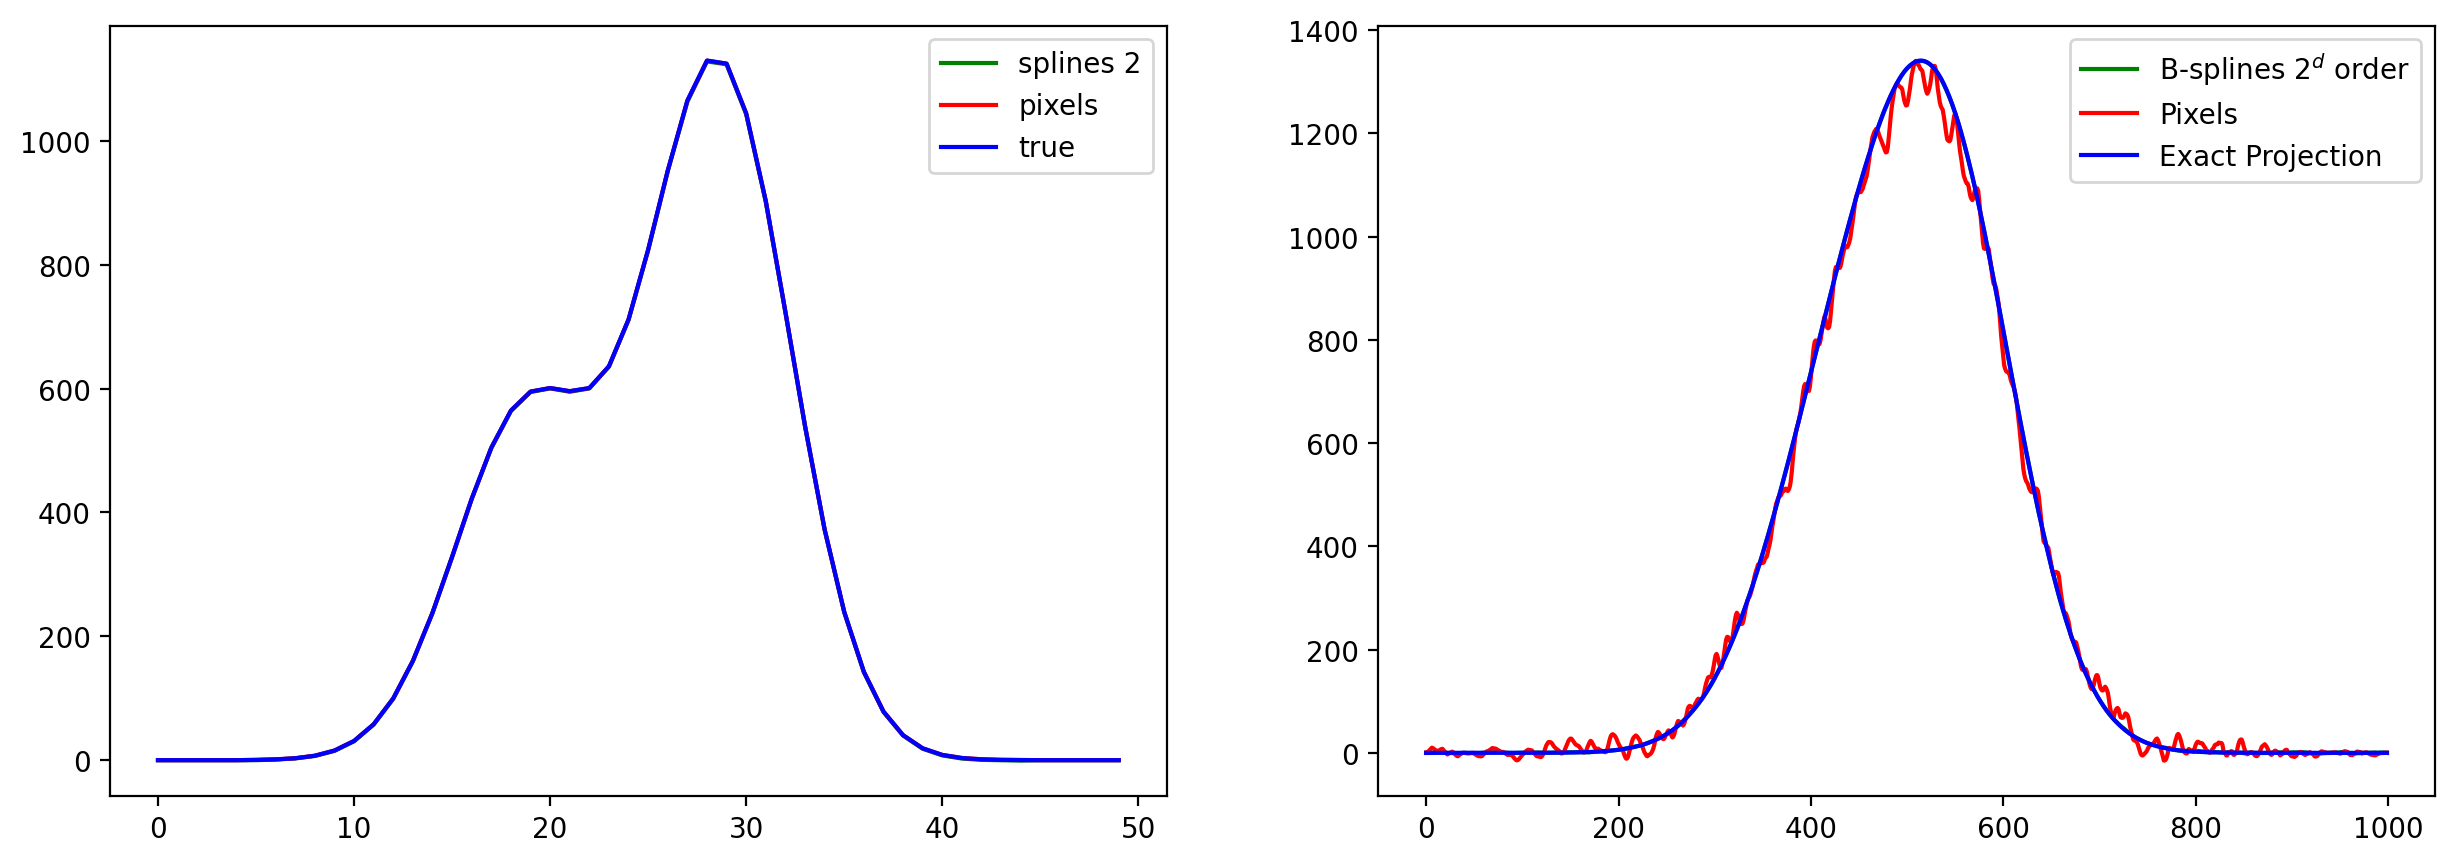

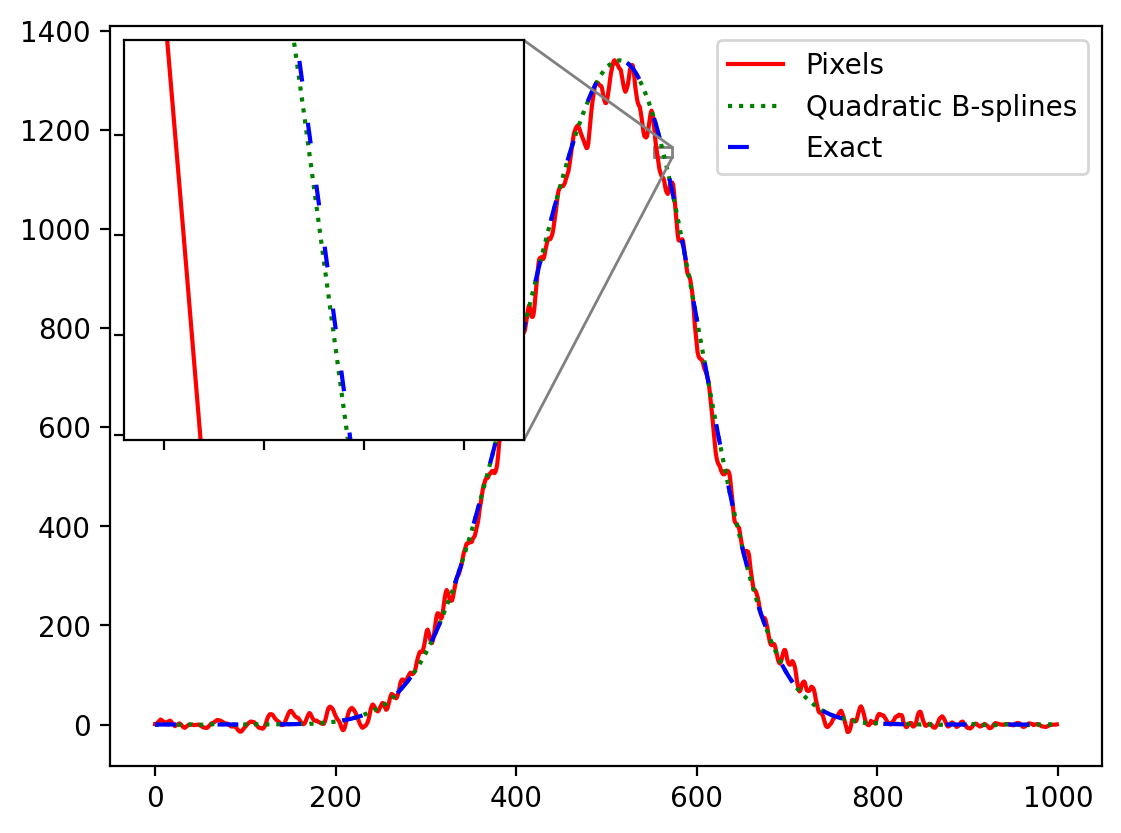

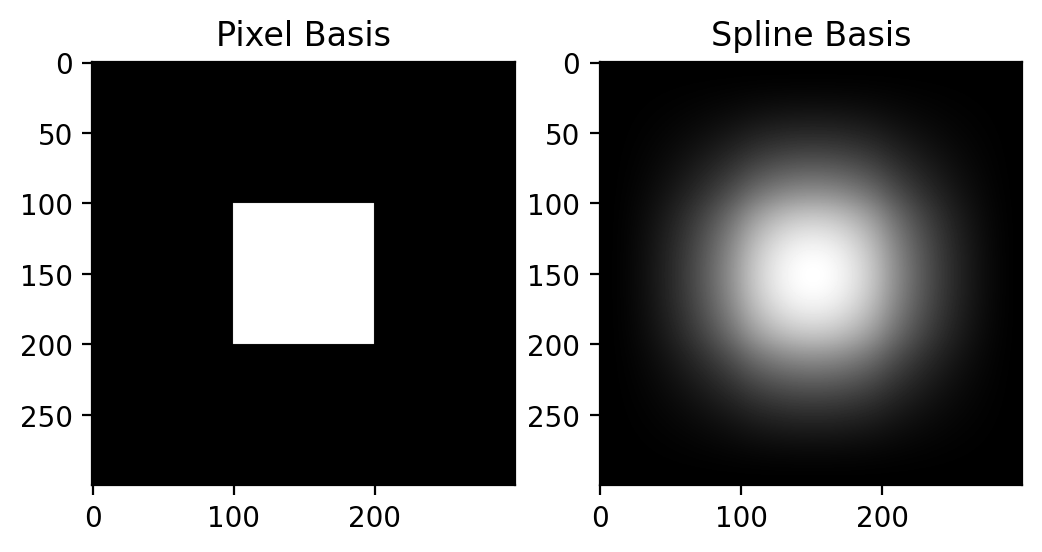

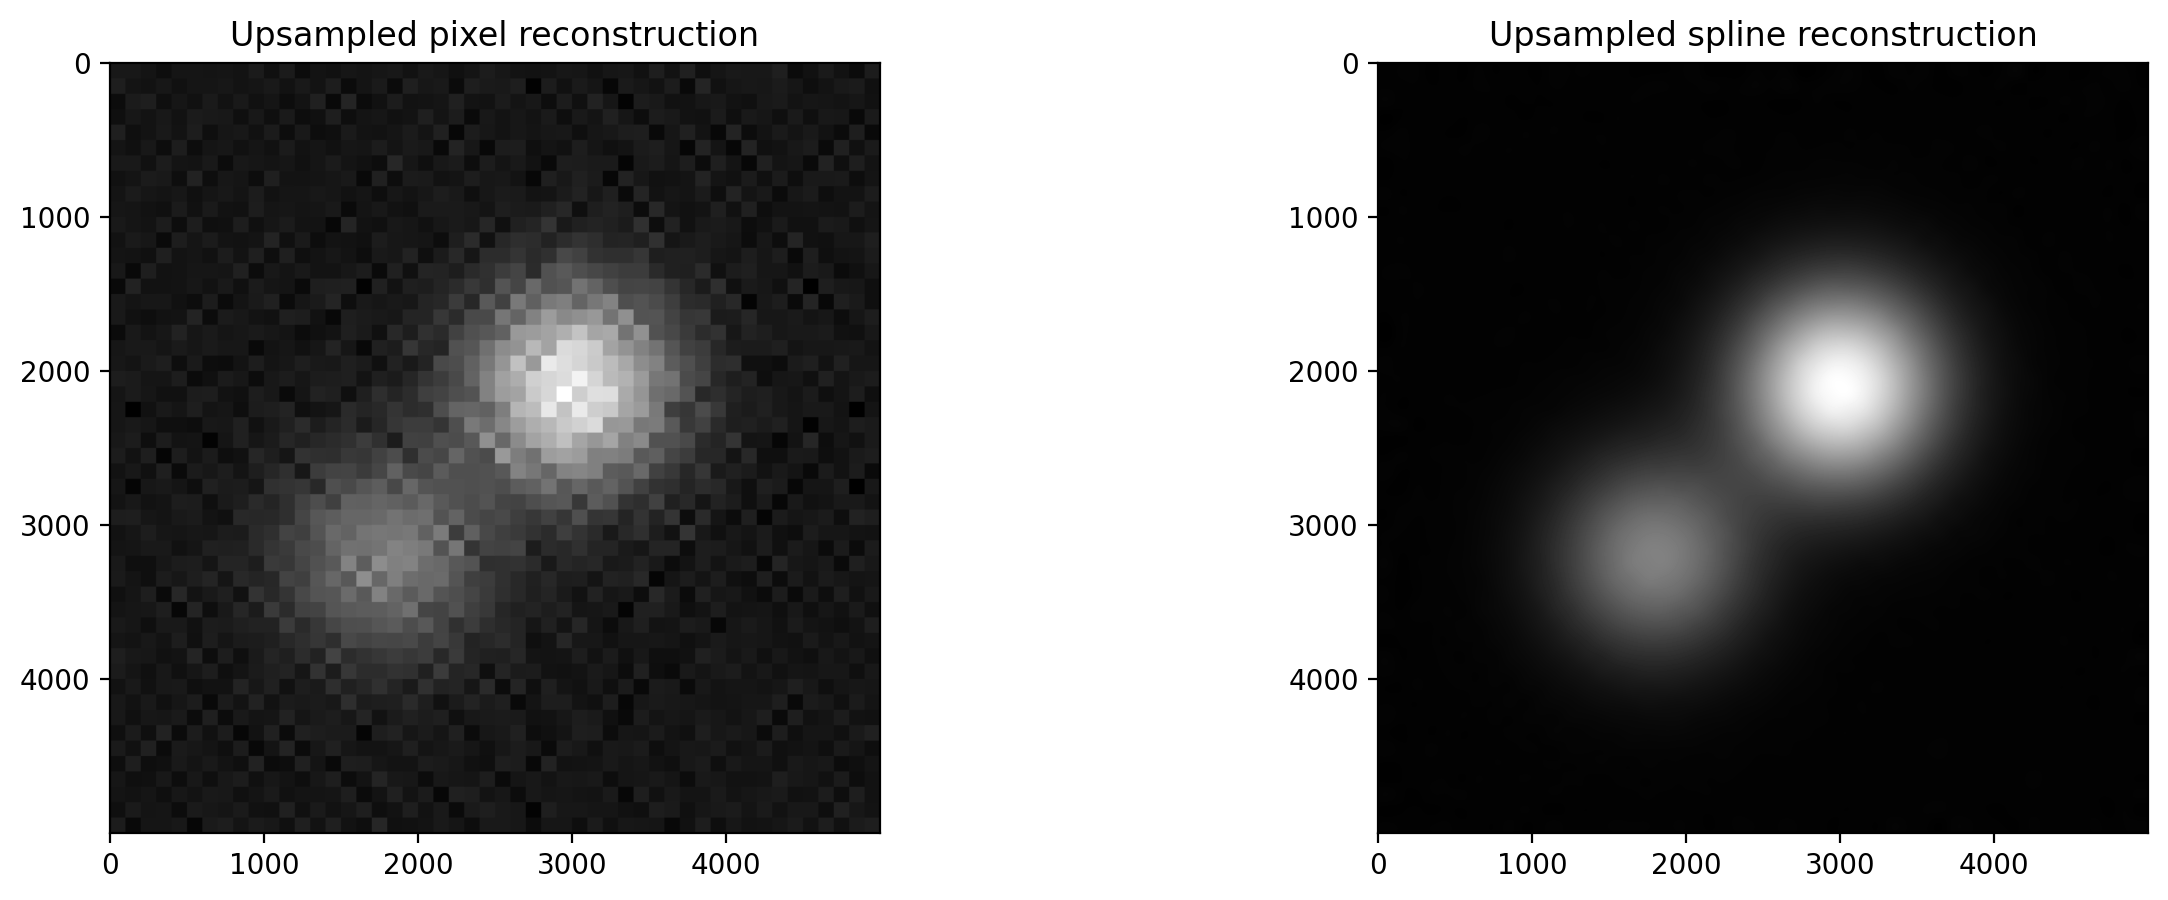

In [9]:


op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)


#N_angle  = 50
N_offset_true = 1000
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset_true, endpoint=True)

n_spec_true  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset_true, 2))  # (N_angle, N_offset_true, 2)
t_spec_true  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset_true, 1)  # (N_angle, N_offset_true, 2)
t_spec_true += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset_true,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec_true  = cp.array(t_spec_true)
n_spec_true  = cp.array(n_spec_true)

op_true = pxr.XRayTransform.init( #for reconstruction
    arg_shape=arg_shape,
    t_spec=t_spec_true.reshape(-1,2), 
    n_spec=n_spec_true.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

stop_crit = pxst.MaxIter(30) #30 before

oversampling = 50
op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)

#add noise
#y_data = np.array(y_data.get()) + 20*np.random.random(y_data.shape)
#y_data = cp.array(y_data)
recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_splines_1.T, cmap='gray')
axes[0, 1].set_title('Sino B-splines $1^d$ order')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()


#N_angle  = 50
N_offset = 1000 
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.2  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

#dotted lines
ax.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')
axins.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')

#dashed lines
ax.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))
axins.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))

x_baseline = 563
y_true = true_proj[9][x_baseline]
x1, x2, y1, y2 = x_baseline-10, x_baseline+10, y_true-10, y_true+10
#505+10, 505+20, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()
plt.savefig('inset.eps', format='eps')

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

# Upsampling to approach continuum

mini_im = np.zeros((300,300))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[100:200, 100:200] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#plt.figure('pix upsampling')
#plt.imshow(mini_im_pix, cmap='gray')
ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[100:200, 100:200], mode='same')/100**2
mini_im_spline = spconv(mini_im_spline, mini_im_pix[100:200, 100:200], mode='same')/100**2
#plt.figure()
#plt.imshow(mini_im_spline)
ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((5200,5200))
for i in range(50):
    for j in range(50):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((5200,5200))
for i in range(50):
    for j in range(50):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('upsampled pix')
#plt.imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].set_title('Upsampled pixel reconstruction')
#plt.figure('upsampled spline')
#plt.imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[1].imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[1].set_title('Upsampled spline reconstruction')

#plt.figure('diff pix')
#plt.imshow(full_im_pix[100:-100, 100:-100] - phantom.get(), cmap='gray')
#plt.figure('diff splines')
#plt.imshow(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get(), cmap='gray')


print(np.linalg.norm(full_im_pix[100:-100, 100:-100] - phantom.get()))
print(np.linalg.norm(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get()))
plt.show()

In [10]:
import astra
from skimage.transform import radon, iradon

N = 50
angles = np.linspace(0, np.pi, N, endpoint=False)
sinogram = sinogram_astra
phantom = np.array(phantom)

vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
proj_geom = astra.create_proj_geom('parallel', 100., N, angles)
proj_id = astra.create_projector('line', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(phantom, proj_id)

plt.figure('phantom')  
plt.imshow(phantom, cmap='gray')

plt.figure('sinogram')
plt.imshow(sinogram, cmap='gray')
plt.show()


proj_geom = astra.create_proj_geom('parallel', 1., N, angles)
vol_geom  = astra.create_vol_geom(N,N)

proj_id = astra.create_projector('line', proj_geom, vol_geom)
sino_id   = astra.data2d.create('-sino', proj_geom, sinogram)
rec_id    = astra.data2d.create('-vol', vol_geom)

cfg       = astra.astra_dict('CGLS')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId']      = sino_id
cfg['ProjectorId']          = proj_id

alg_id    = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 50)
reconstruction              = astra.data2d.get(rec_id)
plt.figure('reconstruction')
plt.imshow(reconstruction , cmap='gray')
plt.figure('diff')
plt.imshow(reconstruction/np.max(reconstruction) - rec_pix/np.max(rec_pix), cmap='gray')
plt.colorbar()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rec_pix, cmap='gray')
ax[1].imshow(reconstruction, cmap='gray')
ax[2].imshow(rec_pix/np.max(rec_pix) - reconstruction/np.max(reconstruction), cmap='gray')
for a in ax:
    a.axis('off')
#colorbar
fig.colorbar(ax[2].imshow(rec_pix/np.max(rec_pix) - reconstruction/np.max(reconstruction), cmap='gray'))
plt.savefig('diff_reconstruction.eps', format='eps')
plt.show()



TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.